In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_cat_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_cat_feature.f')
print(test_.shape)

(8359, 992)
(8360, 987)


In [3]:
n_fold = 5

In [4]:
train_.loc[train_['Developer'].isnull(), 'Developer'] = 'None'
train_.loc[train_['Rating'].isnull(), 'Rating'] = 'None'
train_.loc[train_['Genre'].isnull(), 'Genre'] = 'None'
test_.loc[test_['Developer'].isnull(), 'Developer'] = 'None'
test_.loc[test_['Rating'].isnull(), 'Rating'] = 'None'
test_.loc[test_['Genre'].isnull(), 'Genre'] = 'None'

In [5]:
train_.head()

,Name,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,...,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_0,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,LDA_9,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,Wii,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,8.0,7.0,3.135494,2010.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,49.257785,106.536082,49.231678,59.678899,52.633663,56.848214,289.223684,112.428571,64.319444,81.140351,48.326531,50.646154,56.630137,444.419232,148.275892,72.187084,341.484617,73.847985,96.258706,76.873366,69.018125,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.020000,0.020000,0.020002,0.020002,0.020000,0.020000,0.020000,0.020001,0.020000,0.819994,0.000142,0.033639,0.561210,0.000142,0.284224,0.120078,0.000142,0.000142,0.000142,0.000142
1,LEGO Indiana Jones: The Original Adventures,Wii,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,7.0,8.0,3.367296,2008.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,49.148789,66.403374,101.466970,54.090000,48.867470,52.439815,213.160000,54.335079,58.293233,483.589744,89.802260,75.231343,96.758065,462.863031,120.188797,75.206074,174.818593,341.906251,91.001509,72.338596,62.128944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.014286,0.871417,0.014288,0.014289,0.014286,0.014286,0.014286,0.014287,0.014286,0.014291,0.087166,0.567693,0.000369,0.000369,0.079834,0.044268,0.000369,0.000369,0.197542,0.022020
2,LEGO Batman: The Videogame,PSP,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,7.0,7.0,2.397895,2010.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,53.568595,64.981846,46.931655,48.185714,53.033898,58.454936,31.886792,58.615789,60.314286,45.701493,47.107692,53.884615,57.709821,69.859005,132.194405,81.714638,150.222097,77.663440,114.136366,82.460642,74.957223,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.020000,0.020000,0.020002,0.020002,0.020000,0.020000,0.020000,0.020001,0.020000,0.819994,0.000142,0.033639,0.561210,0.000142,0.284224,0.120078,0.000142,0.000142,0.000142,0.000142
3,Combat,2600,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,None,None,0,NaN,NaN,NaN,1982.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,NaN,NaN,NaN,52.269231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.197493,149.6

In [6]:
test_.head()

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,TGE_Global_Sales_mean_by_Genre_Rating,TGE_Global_Sales_mean_by_User_Score_int_Platform,TGE_Global_Sales_mean_by_User_Score_int_Genre,TGE_Global_Sales_mean_by_User_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_Platform,TGE_Global_Sales_mean_by_Critic_Score_int_Genre,TGE_Global_Sales_mean_by_Critic_Score_int_Rating,TGE_Global_Sales_mean_by_Critic_Score_int_User_Score_int,TGE_Global_Sales_std_by_Platform,TGE_Global_Sales_std_by_Genre,TGE_Global_Sales_std_by_Rating,TGE_Global_Sales_std_by_User_Score_int,TGE_Global_Sales_std_by_Critic_Score_int,TGE_Global_Sales_std_by_Platform_Genre,TGE_Global_Sales_std_by_Platform_Rating,TGE_Global_Sales_std_by_Genre_Rating,TGE_Global_Sales_std_by_User_Score_int_Platform,TGE_Global_Sales_std_by_User_Score_int_Genre,TGE_Global_Sales_std_by_User_Score_int_Rating,TGE_Global_Sales_std_by_Critic_Score_int_Platform,TGE_Global_Sales_std_by_Critic_Score_int_Genre,...,WD_crimson,WD_godzilla,WD_skies,WD_hakusho,WD_prophecy,WD_wings,WD_champion,WD_codename,WD_medieval,WD_town,WD_century,WD_atlantis,WD_scene,WD_rome,WD_dino,WD_groove,WD_volleyball,WD_wario,WD_machi,WD_mirai,WD_studio,WD_bandicoot,WD_director,WD_wall,WD_yoru,WD_kane,WD_west,WD_unreal,WD_turismo,WD_redemption,LDA_0,LDA_1,LDA_2,LDA_3,LDA_4,LDA_5,LDA_6,LDA_7,LDA_8,LDA_9,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,XB,Action,Eidos Interactive,84.0,23.0,8.0,19.0,Io Interactive,M,0,8.0,8.0,2.995732,2004.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,34.246377,90.017778,88.489083,111.091346,64.594512,139.218459,203.600983,320.473808,323.717868,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,44.125958,95.640508,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.050025,0.050000,0.050000,0.050000,0.549975,0.050000,0.050000,0.050000,0.050000,0.050000,0.057221,0.494886,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.329648,0.117235
1,Legacy of Kain: Soul Reaver,PS,Action,Eidos Interactive,91.0,17.0,9.0,132.0,Crystal Dynamics,T,0,9.0,9.0,4.890349,1999.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,51.920228,325.000000,156.375000,104.608491,412.666667,190.612903,164.576923,215.804348,129.886997,139.218459,99.850190,235.111932,327.145440,108.623828,289.354320,96.611679,360.629311,287.232653,191.872644,328.886578,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.033337,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.366662,0.366667,0.057221,0.494886,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.329648,0.117235
2,Metal Gear Solid 2: Substance,XB,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,0,8.0,9.0,3.688879,2004.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,118.701987,40.721649,103.318681,123.796512,57.935484,190.612903,201.981308,201.214689,64.594512,139.218459,203.600983,320.473808,327.145440,45.034497,128.072262,266.693331,92.540165,208.199887,235.151522,52.441037,185.067852,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.033333,0.033333,0.033333,0.699998,0.033333,0.033333,0.033333,0.033333,0.033333,0.033335,0.069309,0.005479,0.105457,0.025016,0.027115,0.19

In [7]:
cat_params = {
    'depth' : 6,
    'learning_rate' : 0.01, 
    'eval_metric' :'RMSE', 
    'random_seed' :0,
    'num_boost_round': 10000,
}

In [8]:
categorical_features = ['Platform', 'Genre', 'Developer', 'Rating']

In [9]:
def create_bin_y_folds(X, y):
    num_bins = np.int(1 + np.log2(len(X)))
    print('num_bins: ', num_bins)
    bins = pd.qcut(y, q=num_bins, labels=False)
    kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = kf.split(X=X, y=bins.values)
    return cv

In [10]:
def create_normal_folds(X, y):
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(X)
    return cv

In [11]:
def train_catboost(X, y, params: dict, verbose=100):

    #   cv = create_normal_folds(X, y)
    cv = create_bin_y_folds(X, y)
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[idx_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [12]:
def train_catboost_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[is_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [13]:
def train_pred(train_df, y, test_df, group):
#     oof, models, score = train_catboost_group(train_df, y, group, cat_params)
    oof, models, score = train_catboost(train_df, y, cat_params)
    
    pred_list = []
    for model in models:
            test_pool = Pool(data=test_df, cat_features=categorical_features)
            pred = model.predict(test_pool)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [14]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [15]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

num_bins:  14
x_train (6687, 985)
x_valid (1672, 985)
0:	learn: 1.3905088	test: 1.3765364	best: 1.3765364 (0)	total: 69.5ms	remaining: 11m 35s
100:	learn: 1.1019664	test: 1.0969236	best: 1.0969236 (100)	total: 1.38s	remaining: 2m 15s
200:	learn: 1.0044208	test: 1.0086466	best: 1.0086466 (200)	total: 2.57s	remaining: 2m 5s
300:	learn: 0.9607025	test: 0.9700401	best: 0.9700401 (300)	total: 3.82s	remaining: 2m 3s
400:	learn: 0.9334042	test: 0.9469827	best: 0.9469827 (400)	total: 5.04s	remaining: 2m
500:	learn: 0.9152544	test: 0.9331595	best: 0.9331595 (500)	total: 6.33s	remaining: 1m 59s
600:	learn: 0.9004477	test: 0.9233829	best: 0.9233829 (600)	total: 7.54s	remaining: 1m 57s
700:	learn: 0.8881095	test: 0.9154729	best: 0.9154729 (700)	total: 8.95s	remaining: 1m 58s
800:	learn: 0.8774481	test: 0.9093142	best: 0.9093142 (800)	total: 10.2s	remaining: 1m 56s
900:	learn: 0.8673827	test: 0.9046395	best: 0.9046395 (900)	total: 11.4s	remaining: 1m 55s
1000:	learn: 0.8569264	test: 0.8998171	best:

8900:	learn: 0.5628125	test: 0.8363970	best: 0.8363941 (8899)	total: 1m 40s	remaining: 12.4s
9000:	learn: 0.5608552	test: 0.8360788	best: 0.8360665 (8985)	total: 1m 41s	remaining: 11.3s
9100:	learn: 0.5589739	test: 0.8359332	best: 0.8359185 (9094)	total: 1m 42s	remaining: 10.2s
9200:	learn: 0.5571048	test: 0.8358645	best: 0.8358636 (9199)	total: 1m 44s	remaining: 9.04s
9300:	learn: 0.5550669	test: 0.8354806	best: 0.8354806 (9300)	total: 1m 45s	remaining: 7.91s
9400:	learn: 0.5533644	test: 0.8354176	best: 0.8353914 (9375)	total: 1m 46s	remaining: 6.77s
9500:	learn: 0.5515141	test: 0.8352375	best: 0.8352299 (9498)	total: 1m 47s	remaining: 5.64s
9600:	learn: 0.5498370	test: 0.8350807	best: 0.8350675 (9598)	total: 1m 48s	remaining: 4.51s
9700:	learn: 0.5480986	test: 0.8348900	best: 0.8348825 (9698)	total: 1m 49s	remaining: 3.38s
9800:	learn: 0.5461417	test: 0.8346527	best: 0.8345991 (9788)	total: 1m 50s	remaining: 2.25s
9900:	learn: 0.5444028	test: 0.8343567	best: 0.8343567 (9900)	total: 1

7600:	learn: 0.5967220	test: 0.8357460	best: 0.8357402 (7599)	total: 1m 25s	remaining: 26.9s
7700:	learn: 0.5945188	test: 0.8354530	best: 0.8354372 (7695)	total: 1m 26s	remaining: 25.7s
7800:	learn: 0.5925142	test: 0.8352329	best: 0.8352308 (7799)	total: 1m 27s	remaining: 24.6s
7900:	learn: 0.5899698	test: 0.8349474	best: 0.8349474 (7900)	total: 1m 28s	remaining: 23.5s
8000:	learn: 0.5878264	test: 0.8347179	best: 0.8347179 (8000)	total: 1m 29s	remaining: 22.4s
8100:	learn: 0.5858162	test: 0.8343314	best: 0.8343275 (8099)	total: 1m 30s	remaining: 21.2s
8200:	learn: 0.5838019	test: 0.8341046	best: 0.8341013 (8180)	total: 1m 31s	remaining: 20.1s
8300:	learn: 0.5815601	test: 0.8337606	best: 0.8337606 (8300)	total: 1m 32s	remaining: 19s
8400:	learn: 0.5794236	test: 0.8334852	best: 0.8334612 (8395)	total: 1m 33s	remaining: 17.9s
8500:	learn: 0.5772600	test: 0.8333370	best: 0.8333328 (8476)	total: 1m 35s	remaining: 16.8s
8600:	learn: 0.5753704	test: 0.8332201	best: 0.8332075 (8588)	total: 1m 

6300:	learn: 0.6173395	test: 0.8664833	best: 0.8664833 (6300)	total: 1m 10s	remaining: 41.2s
6400:	learn: 0.6149533	test: 0.8660795	best: 0.8660720 (6399)	total: 1m 11s	remaining: 40.1s
6500:	learn: 0.6123252	test: 0.8655750	best: 0.8655750 (6500)	total: 1m 12s	remaining: 39s
6600:	learn: 0.6099623	test: 0.8650010	best: 0.8650010 (6600)	total: 1m 13s	remaining: 37.9s
6700:	learn: 0.6076999	test: 0.8646711	best: 0.8646711 (6700)	total: 1m 14s	remaining: 36.8s
6800:	learn: 0.6054383	test: 0.8643596	best: 0.8643584 (6799)	total: 1m 15s	remaining: 35.7s
6900:	learn: 0.6028747	test: 0.8639938	best: 0.8639938 (6900)	total: 1m 16s	remaining: 34.5s
7000:	learn: 0.6003335	test: 0.8636079	best: 0.8636045 (6994)	total: 1m 18s	remaining: 33.4s
7100:	learn: 0.5980586	test: 0.8633063	best: 0.8633033 (7091)	total: 1m 19s	remaining: 32.3s
7200:	learn: 0.5956809	test: 0.8629702	best: 0.8629627 (7199)	total: 1m 20s	remaining: 31.2s
7300:	learn: 0.5936265	test: 0.8627127	best: 0.8627127 (7300)	total: 1m 

5100:	learn: 0.6663145	test: 0.8297770	best: 0.8297489 (5099)	total: 57.9s	remaining: 55.6s
5200:	learn: 0.6630854	test: 0.8289447	best: 0.8289418 (5199)	total: 59.1s	remaining: 54.5s
5300:	learn: 0.6599708	test: 0.8282302	best: 0.8282302 (5300)	total: 1m	remaining: 53.3s
5400:	learn: 0.6569433	test: 0.8276309	best: 0.8276309 (5400)	total: 1m 1s	remaining: 52.2s
5500:	learn: 0.6540733	test: 0.8270285	best: 0.8270285 (5499)	total: 1m 2s	remaining: 51.1s
5600:	learn: 0.6511417	test: 0.8262877	best: 0.8262787 (5597)	total: 1m 3s	remaining: 49.9s
5700:	learn: 0.6485460	test: 0.8257655	best: 0.8257655 (5700)	total: 1m 4s	remaining: 48.8s
5800:	learn: 0.6456064	test: 0.8251232	best: 0.8251232 (5800)	total: 1m 5s	remaining: 47.7s
5900:	learn: 0.6429427	test: 0.8246187	best: 0.8246187 (5900)	total: 1m 7s	remaining: 46.5s
6000:	learn: 0.6403274	test: 0.8241272	best: 0.8241272 (6000)	total: 1m 8s	remaining: 45.4s
6100:	learn: 0.6376964	test: 0.8237505	best: 0.8237505 (6100)	total: 1m 9s	remainin

3800:	learn: 0.7017348	test: 0.8520405	best: 0.8520363 (3799)	total: 42.9s	remaining: 1m 9s
3900:	learn: 0.6982411	test: 0.8515209	best: 0.8515205 (3896)	total: 44s	remaining: 1m 8s
4000:	learn: 0.6945339	test: 0.8504800	best: 0.8504800 (4000)	total: 45.1s	remaining: 1m 7s
4100:	learn: 0.6910752	test: 0.8493594	best: 0.8493594 (4100)	total: 46.2s	remaining: 1m 6s
4200:	learn: 0.6881297	test: 0.8487636	best: 0.8487636 (4200)	total: 47.3s	remaining: 1m 5s
4300:	learn: 0.6848814	test: 0.8481828	best: 0.8481828 (4300)	total: 48.5s	remaining: 1m 4s
4400:	learn: 0.6816159	test: 0.8474028	best: 0.8474028 (4400)	total: 49.6s	remaining: 1m 3s
4500:	learn: 0.6782598	test: 0.8467603	best: 0.8467603 (4500)	total: 50.8s	remaining: 1m 2s
4600:	learn: 0.6751762	test: 0.8461046	best: 0.8460919 (4596)	total: 52s	remaining: 1m
4700:	learn: 0.6720899	test: 0.8451001	best: 0.8450921 (4696)	total: 53.1s	remaining: 59.8s
4800:	learn: 0.6687819	test: 0.8446163	best: 0.8446081 (4799)	total: 54.2s	remaining: 5

In [16]:
# feature_importance(models).head(50)

In [17]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 22.4455384116611
max= 512.4205491448812


Text(0.5, 0, 'Global_Sales')

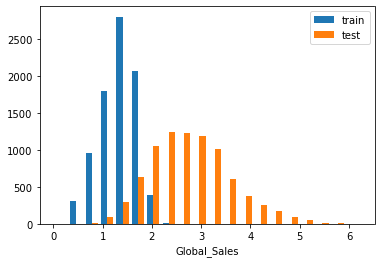

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [19]:
FILENAME = 'submission_cat.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_cat.csv


In [20]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- cat = {:.4f}'.format(score))

- feat = 985
- mean = 22.4455
- max = 512.4205
- cat = 0.8316


#### 29cat: Name減らす
- feat = 985
- mean = 22.4455
- max = 512.4205
- cat = 0.8316
- LB = 

#### 28cat: groupKfold -> StratifiedKFold
- feat = 1431
- mean = 25.0991
- max = 696.4872
- cat = 0.8369
- LB = 0.9006

#### 27cat
- feat = 1431
- mean = 23.7676
- max = 432.5676
- cat = 1.0556

#### 26cat
- feat = 1442
- mean = 21.8695
- max = 382.0561
- cat = 1.0572

#### 25cat
- feat = 1432
- mean = 24.9464
- max = 505.2158
- cat = 1.0565

#### 23cat
- feat = 1452
- mean = 16.5429
- max = 335.4926
- cat = 1.0367

#### 22cat: catboost
- feat = 1432
- mean = 24.2944
- max = 516.1847
- cat = 1.0980

#### 21cat: catboost (learning_rate=0.01)
- feat = 1421
- mean = 24.3766
- max = 526.5783
- score = 1.0733
- LB= 0.9055

#### 20cat: catboost
- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017
- LB= 0.929

#### 20lgbm
- feat = 1421
- mean = 24.6853
- max = 532.8670
- score = 1.0875

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★